In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Reading plate number dataset

In [ ]:
!kaggle datasets download -d aslanahmedov/number-plate-detection

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection
License(s): copyright-authors


In [ ]:
!unzip /content/number-plate-detection.zip -d plate_data

Total files: 453


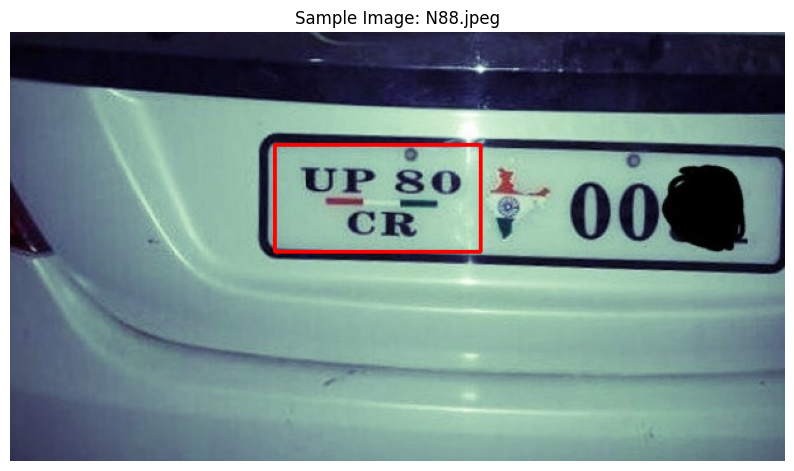

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Path to extracted data
data_path = '/content/plate_data/images'

# List files
files = os.listdir(data_path)
print(f"Total files: {len(files)}")

# Pick a sample image
sample_image_file = [f for f in files if f.endswith('.jpeg')][0]
sample_image_path = os.path.join(data_path, sample_image_file)

# Display the sample image
img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Corresponding XML file
xml_file = sample_image_file.replace('.jpeg', '.xml')
xml_path = os.path.join(data_path, xml_file)

# Parse XML for bounding box
tree = ET.parse(xml_path)
root = tree.getroot()

# Read bounding boxes
for member in root.findall('object'):
    bndbox = member.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # Draw rectangle
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

# Show the image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"Sample Image: {sample_image_file}")
plt.show()


## Checking for distribution of feautures

### Blurriness of the images

100%|██████████| 225/225 [00:02<00:00, 84.01it/s]


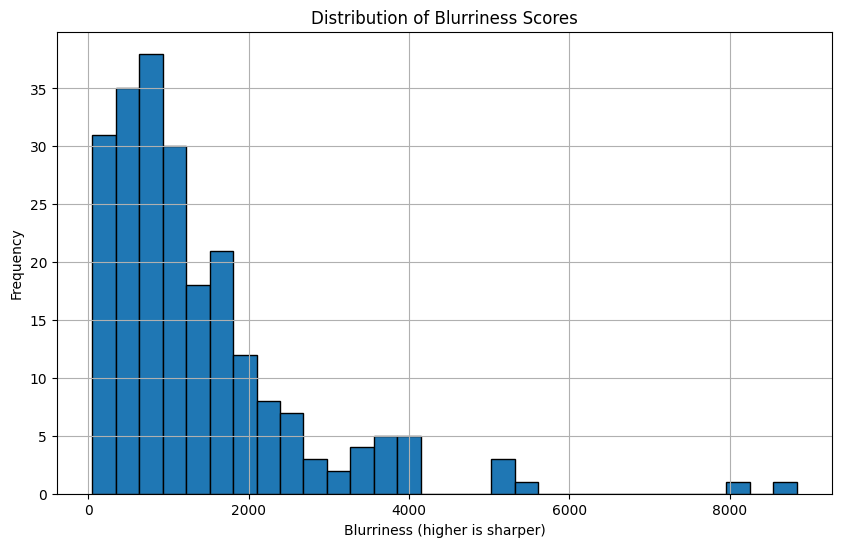

In [ ]:
# Function to measure blurriness
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Add blurriness info
bluriness_scores = []
for file in tqdm(df['filename']):
    img_path = os.path.join(data_path, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        score = variance_of_laplacian(img)
        bluriness_scores.append(score)
    else:
        bluriness_scores.append(0)

df['blurriness'] = bluriness_scores

# Plot blurriness
plt.figure(figsize=(10,6))
plt.hist(df['blurriness'], bins=30, edgecolor='black')
plt.title('Distribution of Blurriness Scores')
plt.xlabel('Blurriness (higher is sharper)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**Obseravtions**  
Majority of your dataset is low-quality (blurry).	Your model might learn to expect blurry images and perform poorly on sharp/clear plates during real-world testing.
Very few sharp (clear) plates.	Sharp plates might be underrepresented. If a clear image appears, the model might misinterpret it because it didn't see enough clear examples.

### Language of the plates

In [ ]:
!pip install paddleocr
!pip install paddlepaddle


In [ ]:
from paddleocr import PaddleOCR
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize PaddleOCR
ocr = PaddleOCR(lang='en')  # You can switch to 'fa' for Persian if needed

# Path to images
data_path = '/content/plate_data/images'

# List jpeg files
image_files = [f for f in os.listdir(data_path) if f.endswith('.jpeg')]

# Store OCR results
ocr_results = []

for img_file in tqdm(image_files[:100]):  # Let's limit to first 100 images to be quick
    img_path = os.path.join(data_path, img_file)
    result = ocr.ocr(img_path, cls=False)

    text_detected = []
    if result and result[0] is not None:  # 👈 check if it's not None
        for line in result[0]:
            text_detected.append(line[1][0])  # Extract detected text

    # Combine all text into one string
    combined_text = ''.join(text_detected)
    ocr_results.append({
        'filename': img_file,
        'text': combined_text
    })

# Convert to dataframe
df_texts = pd.DataFrame(ocr_results)
df_texts.head()


[2025/04/29 02:38:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

  0%|          | 0/100 [00:00<?, ?it/s]

[2025/04/29 02:38:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11954879760742188
[2025/04/29 02:38:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.241227388381958


  1%|          | 1/100 [00:00<00:36,  2.73it/s]

[2025/04/29 02:38:07] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11388707160949707
[2025/04/29 02:38:07] ppocr DEBUG: rec_res num  : 3, elapsed : 0.12480282783508301


  2%|▏         | 2/100 [00:00<00:28,  3.38it/s]

[2025/04/29 02:38:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13615036010742188
[2025/04/29 02:38:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10299301147460938


  3%|▎         | 3/100 [00:00<00:26,  3.66it/s]

[2025/04/29 02:38:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1368391513824463
[2025/04/29 02:38:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11668682098388672


  4%|▍         | 4/100 [00:01<00:25,  3.74it/s]

[2025/04/29 02:38:07] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13726425170898438
[2025/04/29 02:38:08] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4149758815765381


  5%|▌         | 5/100 [00:01<00:35,  2.68it/s]

[2025/04/29 02:38:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1511242389678955
[2025/04/29 02:38:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.12145113945007324


  6%|▌         | 6/100 [00:01<00:32,  2.92it/s]

[2025/04/29 02:38:08] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.32094693183898926
[2025/04/29 02:38:09] ppocr DEBUG: rec_res num  : 8, elapsed : 0.37655019760131836


  7%|▋         | 7/100 [00:02<00:43,  2.16it/s]

[2025/04/29 02:38:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.21524286270141602
[2025/04/29 02:38:09] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1357889175415039


  8%|▊         | 8/100 [00:03<00:39,  2.30it/s]

[2025/04/29 02:38:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.18528366088867188
[2025/04/29 02:38:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22804045677185059


  9%|▉         | 9/100 [00:03<00:39,  2.32it/s]

[2025/04/29 02:38:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09948205947875977
[2025/04/29 02:38:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10210371017456055


 10%|█         | 10/100 [00:03<00:32,  2.76it/s]

[2025/04/29 02:38:10] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1116185188293457
[2025/04/29 02:38:10] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2607250213623047


 11%|█         | 11/100 [00:04<00:32,  2.72it/s]

[2025/04/29 02:38:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12063765525817871
[2025/04/29 02:38:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08755898475646973


 12%|█▏        | 12/100 [00:04<00:28,  3.11it/s]

[2025/04/29 02:38:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1643521785736084
[2025/04/29 02:38:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21092939376831055


 13%|█▎        | 13/100 [00:04<00:29,  2.91it/s]

[2025/04/29 02:38:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16270709037780762
[2025/04/29 02:38:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15200257301330566


 14%|█▍        | 14/100 [00:04<00:29,  2.96it/s]

[2025/04/29 02:38:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.26560401916503906
[2025/04/29 02:38:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20092177391052246


 15%|█▌        | 15/100 [00:05<00:32,  2.58it/s]

[2025/04/29 02:38:12] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17697429656982422
[2025/04/29 02:38:12] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2130894660949707


 16%|█▌        | 16/100 [00:05<00:33,  2.52it/s]

[2025/04/29 02:38:12] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15675640106201172
[2025/04/29 02:38:12] ppocr DEBUG: rec_res num  : 1, elapsed : 0.060677289962768555


 17%|█▋        | 17/100 [00:06<00:28,  2.89it/s]

[2025/04/29 02:38:12] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.16202044486999512
[2025/04/29 02:38:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1756293773651123


 18%|█▊        | 18/100 [00:06<00:28,  2.86it/s]

[2025/04/29 02:38:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10613560676574707
[2025/04/29 02:38:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1506657600402832


 19%|█▉        | 19/100 [00:06<00:26,  3.08it/s]

[2025/04/29 02:38:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08334946632385254
[2025/04/29 02:38:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10166668891906738


 20%|██        | 20/100 [00:06<00:22,  3.52it/s]

[2025/04/29 02:38:13] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1074838638305664
[2025/04/29 02:38:13] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06168055534362793


 21%|██        | 21/100 [00:07<00:19,  3.98it/s]

[2025/04/29 02:38:13] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16222858428955078
[2025/04/29 02:38:13] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10936617851257324


 22%|██▏       | 22/100 [00:07<00:20,  3.83it/s]

[2025/04/29 02:38:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07144880294799805
[2025/04/29 02:38:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16603326797485352


 23%|██▎       | 23/100 [00:07<00:19,  3.90it/s]

[2025/04/29 02:38:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2743091583251953
[2025/04/29 02:38:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1154632568359375


 24%|██▍       | 24/100 [00:08<00:22,  3.33it/s]

[2025/04/29 02:38:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2568392753601074
[2025/04/29 02:38:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08702754974365234


 25%|██▌       | 25/100 [00:08<00:25,  2.89it/s]

[2025/04/29 02:38:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1767597198486328
[2025/04/29 02:38:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10435104370117188


 26%|██▌       | 26/100 [00:08<00:24,  3.04it/s]

[2025/04/29 02:38:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.25145626068115234
[2025/04/29 02:38:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12703561782836914


 27%|██▋       | 27/100 [00:09<00:25,  2.87it/s]

[2025/04/29 02:38:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12795782089233398
[2025/04/29 02:38:16] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35595250129699707


 28%|██▊       | 28/100 [00:09<00:28,  2.55it/s]

[2025/04/29 02:38:16] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.11196446418762207
[2025/04/29 02:38:16] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06


 29%|██▉       | 29/100 [00:09<00:22,  3.21it/s]

[2025/04/29 02:38:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.17258310317993164
[2025/04/29 02:38:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14391088485717773


 30%|███       | 30/100 [00:10<00:22,  3.17it/s]

[2025/04/29 02:38:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14773964881896973
[2025/04/29 02:38:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2586648464202881


 31%|███       | 31/100 [00:10<00:23,  2.89it/s]

[2025/04/29 02:38:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.18299102783203125
[2025/04/29 02:38:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3195688724517822


 32%|███▏      | 32/100 [00:11<00:26,  2.53it/s]

[2025/04/29 02:38:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.16973185539245605
[2025/04/29 02:38:18] ppocr DEBUG: rec_res num  : 6, elapsed : 0.359421968460083


 33%|███▎      | 33/100 [00:11<00:29,  2.28it/s]

[2025/04/29 02:38:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17766427993774414
[2025/04/29 02:38:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24251985549926758


 34%|███▍      | 34/100 [00:12<00:28,  2.29it/s]

[2025/04/29 02:38:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.24116849899291992
[2025/04/29 02:38:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09497499465942383


 35%|███▌      | 35/100 [00:12<00:28,  2.29it/s]

[2025/04/29 02:38:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2619907855987549
[2025/04/29 02:38:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13537144660949707


 36%|███▌      | 36/100 [00:12<00:27,  2.32it/s]

[2025/04/29 02:38:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07663488388061523
[2025/04/29 02:38:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11576008796691895


 37%|███▋      | 37/100 [00:13<00:22,  2.77it/s]

[2025/04/29 02:38:19] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2142045497894287
[2025/04/29 02:38:20] ppocr DEBUG: rec_res num  : 6, elapsed : 0.29711103439331055


 38%|███▊      | 38/100 [00:13<00:25,  2.44it/s]

[2025/04/29 02:38:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.33500099182128906
[2025/04/29 02:38:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2720625400543213


 39%|███▉      | 39/100 [00:14<00:28,  2.11it/s]

[2025/04/29 02:38:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12348175048828125
[2025/04/29 02:38:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09439563751220703


 40%|████      | 40/100 [00:14<00:23,  2.50it/s]

[2025/04/29 02:38:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06962227821350098
[2025/04/29 02:38:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0899202823638916


 41%|████      | 41/100 [00:14<00:19,  3.04it/s]

[2025/04/29 02:38:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06427812576293945
[2025/04/29 02:38:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.13401484489440918


 42%|████▏     | 42/100 [00:14<00:16,  3.43it/s]

[2025/04/29 02:38:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08619952201843262
[2025/04/29 02:38:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16775751113891602


 43%|████▎     | 43/100 [00:15<00:16,  3.54it/s]

[2025/04/29 02:38:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15122270584106445
[2025/04/29 02:38:22] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1996152400970459


 44%|████▍     | 44/100 [00:15<00:17,  3.26it/s]

[2025/04/29 02:38:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08567261695861816
[2025/04/29 02:38:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2064962387084961


 45%|████▌     | 45/100 [00:15<00:16,  3.29it/s]

[2025/04/29 02:38:22] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.23175883293151855
[2025/04/29 02:38:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2535409927368164


 46%|████▌     | 46/100 [00:16<00:19,  2.77it/s]

[2025/04/29 02:38:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12181234359741211
[2025/04/29 02:38:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09125208854675293


 47%|████▋     | 47/100 [00:16<00:16,  3.13it/s]

[2025/04/29 02:38:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14486145973205566
[2025/04/29 02:38:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12630677223205566


 48%|████▊     | 48/100 [00:16<00:16,  3.25it/s]

[2025/04/29 02:38:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.26494789123535156
[2025/04/29 02:38:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10649251937866211


 49%|████▉     | 49/100 [00:17<00:17,  2.84it/s]

[2025/04/29 02:38:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.18061017990112305
[2025/04/29 02:38:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.0921478271484375


 50%|█████     | 50/100 [00:17<00:16,  3.02it/s]

[2025/04/29 02:38:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13623833656311035
[2025/04/29 02:38:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19774317741394043


 51%|█████     | 51/100 [00:17<00:16,  2.98it/s]

[2025/04/29 02:38:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14809131622314453
[2025/04/29 02:38:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09295320510864258


 52%|█████▏    | 52/100 [00:18<00:14,  3.23it/s]

[2025/04/29 02:38:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06526541709899902
[2025/04/29 02:38:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0654442310333252


 53%|█████▎    | 53/100 [00:18<00:12,  3.87it/s]

[2025/04/29 02:38:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1683802604675293
[2025/04/29 02:38:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06737565994262695


 54%|█████▍    | 54/100 [00:18<00:11,  3.93it/s]

[2025/04/29 02:38:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24954700469970703
[2025/04/29 02:38:25] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3097653388977051


 55%|█████▌    | 55/100 [00:19<00:15,  2.86it/s]

[2025/04/29 02:38:25] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2842743396759033
[2025/04/29 02:38:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.16089510917663574


 56%|█████▌    | 56/100 [00:19<00:16,  2.62it/s]

[2025/04/29 02:38:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07144951820373535
[2025/04/29 02:38:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06536197662353516


 57%|█████▋    | 57/100 [00:19<00:13,  3.21it/s]

[2025/04/29 02:38:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.27915048599243164
[2025/04/29 02:38:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.166917085647583


 58%|█████▊    | 58/100 [00:20<00:15,  2.64it/s]

[2025/04/29 02:38:26] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14047527313232422
[2025/04/29 02:38:27] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2517571449279785


 59%|█████▉    | 59/100 [00:20<00:15,  2.60it/s]

[2025/04/29 02:38:27] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.22804641723632812
[2025/04/29 02:38:27] ppocr DEBUG: rec_res num  : 6, elapsed : 0.28630709648132324


 60%|██████    | 60/100 [00:21<00:17,  2.34it/s]

[2025/04/29 02:38:27] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14911246299743652
[2025/04/29 02:38:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3731369972229004


 61%|██████    | 61/100 [00:21<00:17,  2.18it/s]

[2025/04/29 02:38:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.12894892692565918
[2025/04/29 02:38:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3079986572265625


 62%|██████▏   | 62/100 [00:22<00:17,  2.19it/s]

[2025/04/29 02:38:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16627788543701172
[2025/04/29 02:38:28] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12954139709472656


 63%|██████▎   | 63/100 [00:22<00:15,  2.43it/s]

[2025/04/29 02:38:29] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.10889410972595215
[2025/04/29 02:38:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08804821968078613


 64%|██████▍   | 64/100 [00:22<00:12,  2.84it/s]

[2025/04/29 02:38:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.195601224899292
[2025/04/29 02:38:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24689483642578125


 65%|██████▌   | 65/100 [00:23<00:13,  2.61it/s]

[2025/04/29 02:38:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.395662784576416
[2025/04/29 02:38:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.16730499267578125


 66%|██████▌   | 66/100 [00:23<00:15,  2.26it/s]

[2025/04/29 02:38:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11022686958312988
[2025/04/29 02:38:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09711098670959473


 67%|██████▋   | 67/100 [00:23<00:12,  2.67it/s]

[2025/04/29 02:38:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12948942184448242
[2025/04/29 02:38:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1308152675628662


 68%|██████▊   | 68/100 [00:24<00:10,  2.92it/s]

[2025/04/29 02:38:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2682464122772217
[2025/04/29 02:38:31] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5409238338470459


 69%|██████▉   | 69/100 [00:24<00:15,  2.05it/s]

[2025/04/29 02:38:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09523892402648926
[2025/04/29 02:38:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06837749481201172


 70%|███████   | 70/100 [00:25<00:11,  2.55it/s]

[2025/04/29 02:38:31] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15149235725402832
[2025/04/29 02:38:32] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2001962661743164


 71%|███████   | 71/100 [00:25<00:11,  2.61it/s]

[2025/04/29 02:38:32] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.37716245651245117
[2025/04/29 02:38:32] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5190825462341309


 72%|███████▏  | 72/100 [00:26<00:15,  1.85it/s]

[2025/04/29 02:38:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.214585542678833
[2025/04/29 02:38:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16647934913635254


 73%|███████▎  | 73/100 [00:26<00:13,  2.01it/s]

[2025/04/29 02:38:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09282183647155762
[2025/04/29 02:38:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20745325088500977


 74%|███████▍  | 74/100 [00:27<00:11,  2.27it/s]

[2025/04/29 02:38:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08106851577758789
[2025/04/29 02:38:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12321996688842773


 75%|███████▌  | 75/100 [00:27<00:09,  2.69it/s]

[2025/04/29 02:38:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.06482291221618652
[2025/04/29 02:38:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09319806098937988


 76%|███████▌  | 76/100 [00:27<00:07,  3.24it/s]

[2025/04/29 02:38:34] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1826310157775879
[2025/04/29 02:38:34] ppocr DEBUG: rec_res num  : 5, elapsed : 0.25960874557495117


 77%|███████▋  | 77/100 [00:27<00:08,  2.84it/s]

[2025/04/29 02:38:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13178539276123047
[2025/04/29 02:38:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09060502052307129


 78%|███████▊  | 78/100 [00:28<00:06,  3.16it/s]

[2025/04/29 02:38:34] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1713886260986328
[2025/04/29 02:38:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.26375722885131836


 79%|███████▉  | 79/100 [00:28<00:07,  2.82it/s]

[2025/04/29 02:38:35] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.09040069580078125
[2025/04/29 02:38:35] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21969366073608398


 80%|████████  | 80/100 [00:28<00:06,  2.92it/s]

[2025/04/29 02:38:35] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.19314098358154297
[2025/04/29 02:38:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12861323356628418


 81%|████████  | 81/100 [00:29<00:06,  2.94it/s]

[2025/04/29 02:38:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09759998321533203
[2025/04/29 02:38:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05966353416442871


 82%|████████▏ | 82/100 [00:29<00:05,  3.48it/s]

[2025/04/29 02:38:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07940483093261719
[2025/04/29 02:38:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13282394409179688


 83%|████████▎ | 83/100 [00:29<00:04,  3.75it/s]

[2025/04/29 02:38:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14087891578674316
[2025/04/29 02:38:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10100960731506348


 84%|████████▍ | 84/100 [00:29<00:04,  3.82it/s]

[2025/04/29 02:38:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07102823257446289
[2025/04/29 02:38:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09459447860717773


 85%|████████▌ | 85/100 [00:30<00:03,  4.26it/s]

[2025/04/29 02:38:36] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.1693265438079834
[2025/04/29 02:38:37] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3374204635620117


 86%|████████▌ | 86/100 [00:30<00:04,  3.13it/s]

[2025/04/29 02:38:37] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15415000915527344
[2025/04/29 02:38:37] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17766928672790527


 87%|████████▋ | 87/100 [00:30<00:04,  3.07it/s]

[2025/04/29 02:38:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.10721945762634277
[2025/04/29 02:38:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09278726577758789


 88%|████████▊ | 88/100 [00:31<00:03,  3.45it/s]

[2025/04/29 02:38:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.26195693016052246
[2025/04/29 02:38:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10366320610046387


 89%|████████▉ | 89/100 [00:31<00:03,  3.17it/s]

[2025/04/29 02:38:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13952994346618652
[2025/04/29 02:38:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06450390815734863


 90%|█████████ | 90/100 [00:31<00:02,  3.52it/s]

[2025/04/29 02:38:38] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2316901683807373
[2025/04/29 02:38:38] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22804689407348633


 91%|█████████ | 91/100 [00:32<00:03,  2.89it/s]

[2025/04/29 02:38:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08800625801086426
[2025/04/29 02:38:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.13150739669799805


 92%|█████████▏| 92/100 [00:32<00:02,  3.22it/s]

[2025/04/29 02:38:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2546696662902832
[2025/04/29 02:38:40] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7847628593444824


 93%|█████████▎| 93/100 [00:33<00:03,  1.87it/s]

[2025/04/29 02:38:40] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08939170837402344
[2025/04/29 02:38:40] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1445167064666748


 94%|█████████▍| 94/100 [00:33<00:02,  2.24it/s]

[2025/04/29 02:38:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11243247985839844
[2025/04/29 02:38:40] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07196640968322754


 95%|█████████▌| 95/100 [00:33<00:01,  2.70it/s]

[2025/04/29 02:38:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16305279731750488
[2025/04/29 02:38:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.30256223678588867


 96%|█████████▌| 96/100 [00:34<00:01,  2.48it/s]

[2025/04/29 02:38:41] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1314702033996582
[2025/04/29 02:38:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09294581413269043


 97%|█████████▋| 97/100 [00:34<00:01,  2.82it/s]

[2025/04/29 02:38:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1555156707763672
[2025/04/29 02:38:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.31998610496520996


 98%|█████████▊| 98/100 [00:35<00:00,  2.53it/s]

[2025/04/29 02:38:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1811656951904297
[2025/04/29 02:38:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.20249485969543457


 99%|█████████▉| 99/100 [00:35<00:00,  2.53it/s]

[2025/04/29 02:38:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16643977165222168
[2025/04/29 02:38:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10030007362365723


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


,filename,text
0,N88.jpeg,UP8000CR
1,N99.jpeg,MH03BS7778
2,N215.jpeg,MH02CB4545
3,N180.jpeg,0001
4,N245.jpeg,www.marutiwagonr.comSMS.wagonr to 53636MH06AW8...


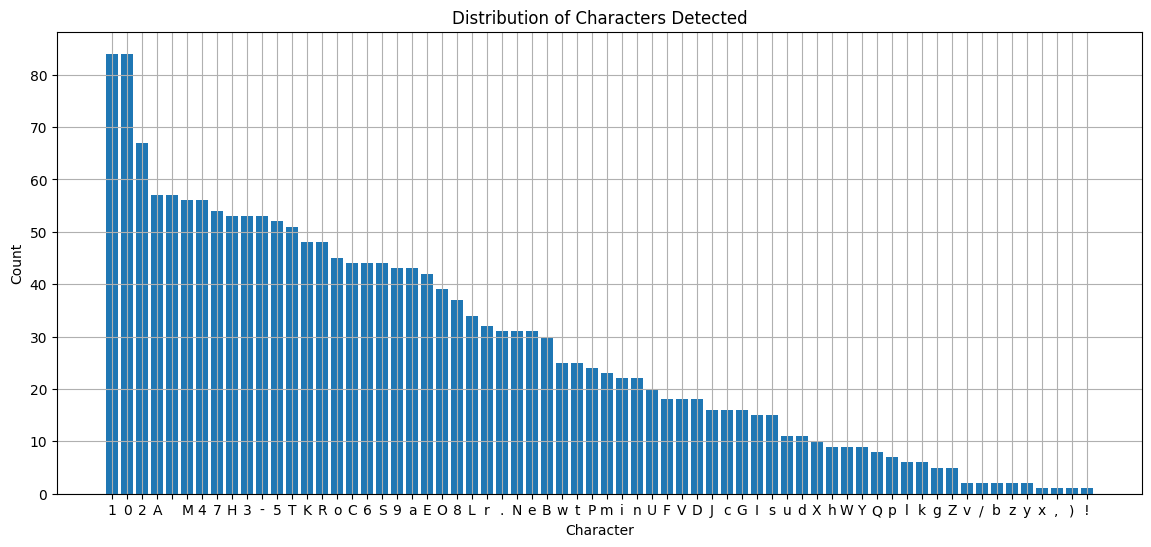

,character,count
15,1,84
3,0,84
12,2,67
30,A,57
28,,57
...,...,...
62,y,2
56,x,1
55,",",1
61,),1


In [ ]:
from collections import Counter

# Combine all detected texts
all_text = ''.join(df_texts['text'].tolist())

# Count characters
char_counter = Counter(all_text)

# Convert to DataFrame for visualization
char_df = pd.DataFrame(char_counter.items(), columns=['character', 'count']).sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(14,6))
plt.bar(char_df['character'], char_df['count'])
plt.title('Distribution of Characters Detected')
plt.xlabel('Character')
plt.ylabel('Count')
plt.grid(True)
plt.show()

char_df


So, the distrubution is just showing us eng letters. but we may have failed to read those images with OCR and if we checked those and see letters from other languages we will see if we have issues reading non-english plates.

  0%|          | 0/228 [00:00<?, ?it/s]

[2025/04/29 03:32:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11029386520385742
[2025/04/29 03:32:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20337247848510742


  0%|          | 1/228 [00:00<01:12,  3.12it/s]

[2025/04/29 03:32:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11732697486877441
[2025/04/29 03:32:12] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1589515209197998


  1%|          | 2/228 [00:00<01:07,  3.35it/s]

[2025/04/29 03:32:12] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14653897285461426
[2025/04/29 03:32:12] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10890960693359375


  1%|▏         | 3/228 [00:00<01:03,  3.54it/s]

[2025/04/29 03:32:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1528034210205078
[2025/04/29 03:32:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14741921424865723


  2%|▏         | 4/228 [00:01<01:05,  3.42it/s]

[2025/04/29 03:32:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.14010834693908691
[2025/04/29 03:32:13] ppocr DEBUG: rec_res num  : 5, elapsed : 0.4752194881439209


  2%|▏         | 5/228 [00:01<01:31,  2.43it/s]

[2025/04/29 03:32:13] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15480971336364746
[2025/04/29 03:32:13] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14825057983398438


  3%|▎         | 6/228 [00:02<01:23,  2.65it/s]

[2025/04/29 03:32:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.27461719512939453
[2025/04/29 03:32:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.4222133159637451


  3%|▎         | 7/228 [00:02<01:47,  2.05it/s]

[2025/04/29 03:32:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2290816307067871
[2025/04/29 03:32:14] ppocr DEBUG: rec_res num  : 2, elapsed : 0.152374267578125


  4%|▎         | 8/228 [00:03<01:41,  2.16it/s]

[2025/04/29 03:32:14] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15275073051452637
[2025/04/29 03:32:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2648792266845703


  4%|▍         | 9/228 [00:03<01:38,  2.22it/s]

[2025/04/29 03:32:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06895613670349121
[2025/04/29 03:32:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12122464179992676


  4%|▍         | 10/228 [00:03<01:21,  2.68it/s]

[2025/04/29 03:32:15] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.11771225929260254
[2025/04/29 03:32:15] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3028557300567627


  5%|▍         | 11/228 [00:04<01:24,  2.57it/s]

[2025/04/29 03:32:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13292527198791504
[2025/04/29 03:32:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09808707237243652


  5%|▌         | 12/228 [00:04<01:14,  2.91it/s]

[2025/04/29 03:32:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17233538627624512
[2025/04/29 03:32:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.24157977104187012


  6%|▌         | 13/228 [00:04<01:19,  2.69it/s]

[2025/04/29 03:32:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17632818222045898
[2025/04/29 03:32:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17269158363342285


  6%|▌         | 14/228 [00:05<01:18,  2.72it/s]

[2025/04/29 03:32:17] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.27698373794555664
[2025/04/29 03:32:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24727153778076172


  7%|▋         | 15/228 [00:05<01:30,  2.34it/s]

[2025/04/29 03:32:17] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17324280738830566
[2025/04/29 03:32:17] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2464306354522705


  7%|▋         | 16/228 [00:06<01:32,  2.30it/s]

[2025/04/29 03:32:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1623213291168213
[2025/04/29 03:32:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06923604011535645


  7%|▋         | 17/228 [00:06<01:19,  2.66it/s]

[2025/04/29 03:32:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.18055462837219238
[2025/04/29 03:32:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2159862518310547


  8%|▊         | 18/228 [00:06<01:21,  2.57it/s]

[2025/04/29 03:32:18] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07859015464782715
[2025/04/29 03:32:18] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17569422721862793


  8%|▊         | 19/228 [00:07<01:13,  2.85it/s]

[2025/04/29 03:32:18] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08764886856079102
[2025/04/29 03:32:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14250707626342773


  9%|▉         | 20/228 [00:07<01:05,  3.16it/s]

[2025/04/29 03:32:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.111541748046875
[2025/04/29 03:32:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07308101654052734


  9%|▉         | 21/228 [00:07<00:57,  3.59it/s]

[2025/04/29 03:32:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16458392143249512
[2025/04/29 03:32:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12045001983642578


 10%|▉         | 22/228 [00:07<00:58,  3.52it/s]

[2025/04/29 03:32:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0733785629272461
[2025/04/29 03:32:19] ppocr DEBUG: rec_res num  : 3, elapsed : 0.26117658615112305


 10%|█         | 23/228 [00:08<01:01,  3.32it/s]

[2025/04/29 03:32:20] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.39180922508239746
[2025/04/29 03:32:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.20321393013000488


 11%|█         | 24/228 [00:08<01:20,  2.53it/s]

[2025/04/29 03:32:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37119507789611816
[2025/04/29 03:32:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14923644065856934


 11%|█         | 25/228 [00:09<01:37,  2.07it/s]

[2025/04/29 03:32:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1340646743774414
[2025/04/29 03:32:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09637951850891113


 11%|█▏        | 26/228 [00:09<01:22,  2.44it/s]

[2025/04/29 03:32:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2767181396484375
[2025/04/29 03:32:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15407538414001465


 12%|█▏        | 27/228 [00:10<01:24,  2.38it/s]

[2025/04/29 03:32:21] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.13040518760681152
[2025/04/29 03:32:22] ppocr DEBUG: rec_res num  : 5, elapsed : 0.35208654403686523


 12%|█▏        | 28/228 [00:10<01:28,  2.26it/s]

[2025/04/29 03:32:22] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.11569333076477051
[2025/04/29 03:32:22] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


 13%|█▎        | 29/228 [00:10<01:08,  2.89it/s]

[2025/04/29 03:32:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12457776069641113
[2025/04/29 03:32:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13524246215820312


 13%|█▎        | 30/228 [00:11<01:03,  3.10it/s]

[2025/04/29 03:32:22] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11605548858642578
[2025/04/29 03:32:23] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1984264850616455


 14%|█▎        | 31/228 [00:11<01:03,  3.10it/s]

[2025/04/29 03:32:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11618876457214355
[2025/04/29 03:32:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22600722312927246


 14%|█▍        | 32/228 [00:11<01:04,  3.02it/s]

[2025/04/29 03:32:23] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.12560462951660156
[2025/04/29 03:32:23] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4005773067474365


 14%|█▍        | 33/228 [00:12<01:16,  2.55it/s]

[2025/04/29 03:32:24] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.22394514083862305
[2025/04/29 03:32:24] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2687809467315674


 15%|█▍        | 34/228 [00:12<01:22,  2.35it/s]

[2025/04/29 03:32:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.26851511001586914
[2025/04/29 03:32:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10649824142456055


 15%|█▌        | 35/228 [00:13<01:25,  2.25it/s]

[2025/04/29 03:32:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.26766324043273926
[2025/04/29 03:32:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14458632469177246


 16%|█▌        | 36/228 [00:13<01:24,  2.27it/s]

[2025/04/29 03:32:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.04423809051513672
[2025/04/29 03:32:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10505819320678711


 16%|█▌        | 37/228 [00:13<01:07,  2.82it/s]

[2025/04/29 03:32:25] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.2173302173614502
[2025/04/29 03:32:26] ppocr DEBUG: rec_res num  : 6, elapsed : 0.34282588958740234


 17%|█▋        | 38/228 [00:14<01:19,  2.38it/s]

[2025/04/29 03:32:26] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2940807342529297
[2025/04/29 03:32:26] ppocr DEBUG: rec_res num  : 3, elapsed : 0.29432010650634766


 17%|█▋        | 39/228 [00:15<01:30,  2.10it/s]

[2025/04/29 03:32:26] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14136791229248047
[2025/04/29 03:32:26] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08092141151428223


 18%|█▊        | 40/228 [00:15<01:15,  2.49it/s]

[2025/04/29 03:32:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06739926338195801
[2025/04/29 03:32:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10358953475952148


 18%|█▊        | 41/228 [00:15<01:02,  2.99it/s]

[2025/04/29 03:32:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06656599044799805
[2025/04/29 03:32:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17903685569763184


 18%|█▊        | 42/228 [00:15<00:57,  3.23it/s]

[2025/04/29 03:32:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08436179161071777
[2025/04/29 03:32:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18839311599731445


 19%|█▉        | 43/228 [00:16<00:55,  3.32it/s]

[2025/04/29 03:32:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10956835746765137
[2025/04/29 03:32:27] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23128247261047363


 19%|█▉        | 44/228 [00:16<00:58,  3.16it/s]

[2025/04/29 03:32:28] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08626461029052734
[2025/04/29 03:32:28] ppocr DEBUG: rec_res num  : 2, elapsed : 0.22019243240356445


 20%|█▉        | 45/228 [00:16<00:57,  3.17it/s]

[2025/04/29 03:32:28] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2219986915588379
[2025/04/29 03:32:28] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26494550704956055


 20%|██        | 46/228 [00:17<01:07,  2.70it/s]

[2025/04/29 03:32:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13547158241271973
[2025/04/29 03:32:29] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09979987144470215


 21%|██        | 47/228 [00:17<00:59,  3.02it/s]

[2025/04/29 03:32:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1480109691619873
[2025/04/29 03:32:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1397690773010254


 21%|██        | 48/228 [00:17<00:57,  3.12it/s]

[2025/04/29 03:32:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.27054405212402344
[2025/04/29 03:32:29] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10703134536743164


 21%|██▏       | 49/228 [00:18<01:04,  2.76it/s]

[2025/04/29 03:32:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.19494414329528809
[2025/04/29 03:32:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11005353927612305


 22%|██▏       | 50/228 [00:18<01:01,  2.87it/s]

[2025/04/29 03:32:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13834452629089355
[2025/04/29 03:32:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2314298152923584


 22%|██▏       | 51/228 [00:18<01:03,  2.80it/s]

[2025/04/29 03:32:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14603853225708008
[2025/04/29 03:32:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1098930835723877


 23%|██▎       | 52/228 [00:19<00:57,  3.04it/s]

[2025/04/29 03:32:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06824135780334473
[2025/04/29 03:32:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06850433349609375


 23%|██▎       | 53/228 [00:19<00:47,  3.66it/s]

[2025/04/29 03:32:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.17506027221679688
[2025/04/29 03:32:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06595516204833984


 24%|██▎       | 54/228 [00:19<00:46,  3.76it/s]

[2025/04/29 03:32:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.24709248542785645
[2025/04/29 03:32:31] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3129770755767822


 24%|██▍       | 55/228 [00:20<01:01,  2.80it/s]

[2025/04/29 03:32:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2663230895996094
[2025/04/29 03:32:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19001984596252441


 25%|██▍       | 56/228 [00:20<01:07,  2.55it/s]

[2025/04/29 03:32:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07019710540771484
[2025/04/29 03:32:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0829935073852539


 25%|██▌       | 57/228 [00:20<00:55,  3.11it/s]

[2025/04/29 03:32:32] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.4300379753112793
[2025/04/29 03:32:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.27387189865112305


 25%|██▌       | 58/228 [00:21<01:20,  2.11it/s]

[2025/04/29 03:32:33] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.17785024642944336
[2025/04/29 03:32:33] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3615889549255371


 26%|██▌       | 59/228 [00:22<01:24,  2.00it/s]

[2025/04/29 03:32:34] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.32454419136047363
[2025/04/29 03:32:34] ppocr DEBUG: rec_res num  : 6, elapsed : 0.4462573528289795


 26%|██▋       | 60/228 [00:22<01:38,  1.71it/s]

[2025/04/29 03:32:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.21587252616882324
[2025/04/29 03:32:35] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3266775608062744


 27%|██▋       | 61/228 [00:23<01:36,  1.74it/s]

[2025/04/29 03:32:35] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.08865809440612793
[2025/04/29 03:32:35] ppocr DEBUG: rec_res num  : 5, elapsed : 0.23230981826782227


 27%|██▋       | 62/228 [00:23<01:23,  1.99it/s]

[2025/04/29 03:32:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11519312858581543
[2025/04/29 03:32:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0691535472869873


 28%|██▊       | 63/228 [00:24<01:07,  2.45it/s]

[2025/04/29 03:32:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0736393928527832
[2025/04/29 03:32:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07331347465515137


 28%|██▊       | 64/228 [00:24<00:54,  3.01it/s]

[2025/04/29 03:32:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.13443708419799805
[2025/04/29 03:32:36] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18667030334472656


 29%|██▊       | 65/228 [00:24<00:53,  3.02it/s]

[2025/04/29 03:32:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.274214506149292
[2025/04/29 03:32:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11514496803283691


 29%|██▉       | 66/228 [00:24<00:56,  2.84it/s]

[2025/04/29 03:32:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0713663101196289
[2025/04/29 03:32:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06694865226745605


 29%|██▉       | 67/228 [00:25<00:46,  3.46it/s]

[2025/04/29 03:32:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09826254844665527
[2025/04/29 03:32:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14006400108337402


 30%|██▉       | 68/228 [00:25<00:44,  3.63it/s]

[2025/04/29 03:32:37] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.28635311126708984
[2025/04/29 03:32:37] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5774228572845459


 30%|███       | 69/228 [00:26<01:12,  2.18it/s]

[2025/04/29 03:32:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09962725639343262
[2025/04/29 03:32:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0680396556854248


 31%|███       | 70/228 [00:26<00:58,  2.68it/s]

[2025/04/29 03:32:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14734554290771484
[2025/04/29 03:32:38] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21816229820251465


 31%|███       | 71/228 [00:26<00:58,  2.67it/s]

[2025/04/29 03:32:38] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.3133978843688965
[2025/04/29 03:32:39] ppocr DEBUG: rec_res num  : 10, elapsed : 0.5616166591644287


 32%|███▏      | 72/228 [00:27<01:22,  1.88it/s]

[2025/04/29 03:32:39] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.22704172134399414
[2025/04/29 03:32:39] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1820061206817627


 32%|███▏      | 73/228 [00:28<01:17,  2.01it/s]

[2025/04/29 03:32:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.0942838191986084
[2025/04/29 03:32:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23270654678344727


 32%|███▏      | 74/228 [00:28<01:09,  2.23it/s]

[2025/04/29 03:32:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08320808410644531
[2025/04/29 03:32:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13660073280334473


 33%|███▎      | 75/228 [00:28<00:58,  2.62it/s]

[2025/04/29 03:32:40] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.06535792350769043
[2025/04/29 03:32:40] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10812711715698242


 33%|███▎      | 76/228 [00:28<00:48,  3.11it/s]

[2025/04/29 03:32:40] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2041490077972412
[2025/04/29 03:32:40] ppocr DEBUG: rec_res num  : 5, elapsed : 0.26505422592163086


 34%|███▍      | 77/228 [00:29<00:55,  2.71it/s]

[2025/04/29 03:32:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12427449226379395
[2025/04/29 03:32:41] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09817171096801758


 34%|███▍      | 78/228 [00:29<00:49,  3.05it/s]

[2025/04/29 03:32:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16737627983093262
[2025/04/29 03:32:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.28014540672302246


 35%|███▍      | 79/228 [00:29<00:54,  2.73it/s]

[2025/04/29 03:32:41] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.07825970649719238
[2025/04/29 03:32:41] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2187657356262207


 35%|███▌      | 80/228 [00:30<00:51,  2.88it/s]

[2025/04/29 03:32:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.18551898002624512
[2025/04/29 03:32:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1402428150177002


 36%|███▌      | 81/228 [00:30<00:50,  2.90it/s]

[2025/04/29 03:32:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.10287880897521973
[2025/04/29 03:32:42] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06600666046142578


 36%|███▌      | 82/228 [00:30<00:42,  3.40it/s]

[2025/04/29 03:32:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07886195182800293
[2025/04/29 03:32:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15192437171936035


 36%|███▋      | 83/228 [00:31<00:40,  3.61it/s]

[2025/04/29 03:32:42] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14085865020751953
[2025/04/29 03:32:42] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11036896705627441


 37%|███▋      | 84/228 [00:31<00:39,  3.68it/s]

[2025/04/29 03:32:42] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06908774375915527
[2025/04/29 03:32:43] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10636210441589355


 37%|███▋      | 85/228 [00:31<00:35,  4.08it/s]

[2025/04/29 03:32:43] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17177963256835938
[2025/04/29 03:32:43] ppocr DEBUG: rec_res num  : 7, elapsed : 0.3952157497406006


 38%|███▊      | 86/228 [00:32<00:49,  2.90it/s]

[2025/04/29 03:32:43] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15510821342468262
[2025/04/29 03:32:43] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1789238452911377


 38%|███▊      | 87/228 [00:32<00:48,  2.90it/s]

[2025/04/29 03:32:44] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.10789608955383301
[2025/04/29 03:32:44] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11117410659790039


 39%|███▊      | 88/228 [00:32<00:43,  3.24it/s]

[2025/04/29 03:32:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.26622939109802246
[2025/04/29 03:32:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.12647747993469238


 39%|███▉      | 89/228 [00:33<00:46,  2.96it/s]

[2025/04/29 03:32:44] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14073872566223145
[2025/04/29 03:32:44] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07411384582519531


 39%|███▉      | 90/228 [00:33<00:41,  3.30it/s]

[2025/04/29 03:32:45] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.22174501419067383
[2025/04/29 03:32:45] ppocr DEBUG: rec_res num  : 4, elapsed : 0.38324785232543945


 40%|███▉      | 91/228 [00:33<00:54,  2.49it/s]

[2025/04/29 03:32:45] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12763285636901855
[2025/04/29 03:32:45] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21640706062316895


 40%|████      | 92/228 [00:34<00:52,  2.58it/s]

[2025/04/29 03:32:46] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.38347506523132324
[2025/04/29 03:32:46] ppocr DEBUG: rec_res num  : 6, elapsed : 0.6676986217498779


 41%|████      | 93/228 [00:35<01:20,  1.68it/s]

[2025/04/29 03:32:46] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1301736831665039
[2025/04/29 03:32:47] ppocr DEBUG: rec_res num  : 3, elapsed : 0.21793889999389648


 41%|████      | 94/228 [00:35<01:10,  1.91it/s]

[2025/04/29 03:32:47] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1631755828857422
[2025/04/29 03:32:47] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09816884994506836


 42%|████▏     | 95/228 [00:35<00:59,  2.23it/s]

[2025/04/29 03:32:47] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16911053657531738
[2025/04/29 03:32:47] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26284050941467285


 42%|████▏     | 96/228 [00:36<00:58,  2.24it/s]

[2025/04/29 03:32:48] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09169888496398926
[2025/04/29 03:32:48] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06952214241027832


 43%|████▎     | 97/228 [00:36<00:47,  2.75it/s]

[2025/04/29 03:32:48] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10883069038391113
[2025/04/29 03:32:48] ppocr DEBUG: rec_res num  : 4, elapsed : 0.227952241897583


 43%|████▎     | 98/228 [00:36<00:46,  2.79it/s]

[2025/04/29 03:32:48] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13232135772705078
[2025/04/29 03:32:48] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15074992179870605


 43%|████▎     | 99/228 [00:37<00:43,  2.96it/s]

[2025/04/29 03:32:48] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12435150146484375
[2025/04/29 03:32:48] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06823992729187012


 44%|████▍     | 100/228 [00:37<00:37,  3.37it/s]

[2025/04/29 03:32:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10642051696777344
[2025/04/29 03:32:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18239116668701172


 44%|████▍     | 101/228 [00:37<00:37,  3.36it/s]

[2025/04/29 03:32:49] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.22176074981689453
[2025/04/29 03:32:49] ppocr DEBUG: rec_res num  : 2, elapsed : 0.17172598838806152


 45%|████▍     | 102/228 [00:38<00:42,  2.98it/s]

[2025/04/29 03:32:49] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.1789858341217041
[2025/04/29 03:32:50] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2850055694580078


 45%|████▌     | 103/228 [00:38<00:47,  2.62it/s]

[2025/04/29 03:32:50] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.17097735404968262
[2025/04/29 03:32:50] ppocr DEBUG: rec_res num  : 7, elapsed : 0.40916013717651367


 46%|████▌     | 104/228 [00:39<00:55,  2.23it/s]

[2025/04/29 03:32:50] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.18482613563537598
[2025/04/29 03:32:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.28754353523254395


 46%|████▌     | 105/228 [00:39<00:57,  2.14it/s]

[2025/04/29 03:32:51] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1698911190032959
[2025/04/29 03:32:51] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14598894119262695


 46%|████▋     | 106/228 [00:40<00:52,  2.33it/s]

[2025/04/29 03:32:51] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.07677960395812988
[2025/04/29 03:32:51] ppocr DEBUG: rec_res num  : 5, elapsed : 0.27768397331237793


 47%|████▋     | 107/228 [00:40<00:49,  2.44it/s]

[2025/04/29 03:32:52] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06720376014709473
[2025/04/29 03:32:52] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1454792022705078


 47%|████▋     | 108/228 [00:40<00:42,  2.84it/s]

[2025/04/29 03:32:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15491747856140137
[2025/04/29 03:32:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11880159378051758


 48%|████▊     | 109/228 [00:40<00:39,  3.01it/s]

[2025/04/29 03:32:52] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.2719273567199707
[2025/04/29 03:32:53] ppocr DEBUG: rec_res num  : 9, elapsed : 0.47548532485961914


 48%|████▊     | 110/228 [00:41<00:54,  2.16it/s]

[2025/04/29 03:32:53] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16814422607421875
[2025/04/29 03:32:53] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2768843173980713


 49%|████▊     | 111/228 [00:42<00:54,  2.16it/s]

[2025/04/29 03:32:53] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11707448959350586
[2025/04/29 03:32:54] ppocr DEBUG: rec_res num  : 4, elapsed : 0.235276460647583


 49%|████▉     | 112/228 [00:42<00:50,  2.31it/s]

[2025/04/29 03:32:54] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0880591869354248
[2025/04/29 03:32:54] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1431279182434082


 50%|████▉     | 113/228 [00:42<00:43,  2.67it/s]

[2025/04/29 03:32:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09690213203430176
[2025/04/29 03:32:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10631895065307617


 50%|█████     | 114/228 [00:42<00:37,  3.06it/s]

[2025/04/29 03:32:54] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11682391166687012
[2025/04/29 03:32:54] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07508468627929688


 50%|█████     | 115/228 [00:43<00:32,  3.46it/s]

[2025/04/29 03:32:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11402630805969238
[2025/04/29 03:32:56] ppocr DEBUG: rec_res num  : 6, elapsed : 1.5261688232421875


 51%|█████     | 116/228 [00:44<01:18,  1.43it/s]

[2025/04/29 03:32:56] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09752678871154785
[2025/04/29 03:32:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17910408973693848


 51%|█████▏    | 117/228 [00:45<01:03,  1.74it/s]

[2025/04/29 03:32:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08750391006469727
[2025/04/29 03:32:56] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07173681259155273


 52%|█████▏    | 118/228 [00:45<00:49,  2.22it/s]

[2025/04/29 03:32:56] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06267404556274414
[2025/04/29 03:32:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10794878005981445


 52%|█████▏    | 119/228 [00:45<00:40,  2.70it/s]

[2025/04/29 03:32:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12343287467956543
[2025/04/29 03:32:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14931654930114746


 53%|█████▎    | 120/228 [00:45<00:37,  2.90it/s]

[2025/04/29 03:32:57] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2687795162200928
[2025/04/29 03:32:57] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13951778411865234


 53%|█████▎    | 121/228 [00:46<00:39,  2.70it/s]

[2025/04/29 03:32:57] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.19750404357910156
[2025/04/29 03:32:58] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9503402709960938


 54%|█████▎    | 122/228 [00:47<01:04,  1.65it/s]

[2025/04/29 03:32:59] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12016415596008301
[2025/04/29 03:32:59] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13705825805664062


 54%|█████▍    | 123/228 [00:47<00:53,  1.97it/s]

[2025/04/29 03:32:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.24149274826049805
[2025/04/29 03:32:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.35785770416259766


 54%|█████▍    | 124/228 [00:48<00:56,  1.85it/s]

[2025/04/29 03:33:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.37387537956237793
[2025/04/29 03:33:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.3002002239227295


 55%|█████▍    | 125/228 [00:48<01:01,  1.68it/s]

[2025/04/29 03:33:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.1474909782409668
[2025/04/29 03:33:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23556828498840332


 55%|█████▌    | 126/228 [00:49<00:54,  1.86it/s]

[2025/04/29 03:33:01] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2776334285736084
[2025/04/29 03:33:01] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18573236465454102


 56%|█████▌    | 127/228 [00:49<00:52,  1.91it/s]

[2025/04/29 03:33:01] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09193110466003418
[2025/04/29 03:33:01] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11440229415893555


 56%|█████▌    | 128/228 [00:50<00:43,  2.32it/s]

[2025/04/29 03:33:01] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08219766616821289
[2025/04/29 03:33:01] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10166525840759277


 57%|█████▋    | 129/228 [00:50<00:35,  2.79it/s]

[2025/04/29 03:33:02] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1946854591369629
[2025/04/29 03:33:02] ppocr DEBUG: rec_res num  : 2, elapsed : 0.18434691429138184


 57%|█████▋    | 130/228 [00:50<00:36,  2.71it/s]

[2025/04/29 03:33:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09270119667053223
[2025/04/29 03:33:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0678110122680664


 57%|█████▋    | 131/228 [00:50<00:30,  3.23it/s]

[2025/04/29 03:33:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07993125915527344
[2025/04/29 03:33:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07426738739013672


 58%|█████▊    | 132/228 [00:50<00:25,  3.76it/s]

[2025/04/29 03:33:02] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.15129542350769043
[2025/04/29 03:33:03] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5520918369293213


 58%|█████▊    | 133/228 [00:51<00:38,  2.49it/s]

[2025/04/29 03:33:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.1425490379333496
[2025/04/29 03:33:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2206590175628662


 59%|█████▉    | 134/228 [00:52<00:36,  2.54it/s]

[2025/04/29 03:33:04] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.48326683044433594
[2025/04/29 03:33:04] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5530970096588135


 59%|█████▉    | 135/228 [00:53<00:55,  1.68it/s]

[2025/04/29 03:33:04] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08589386940002441
[2025/04/29 03:33:04] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14481592178344727


 60%|█████▉    | 136/228 [00:53<00:44,  2.05it/s]

[2025/04/29 03:33:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09846878051757812
[2025/04/29 03:33:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10896635055541992


 60%|██████    | 137/228 [00:53<00:37,  2.46it/s]

[2025/04/29 03:33:05] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15460729598999023
[2025/04/29 03:33:05] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1099700927734375


 61%|██████    | 138/228 [00:53<00:33,  2.72it/s]

[2025/04/29 03:33:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.10872077941894531
[2025/04/29 03:33:05] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10987710952758789


 61%|██████    | 139/228 [00:54<00:29,  3.07it/s]

[2025/04/29 03:33:05] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.14266347885131836
[2025/04/29 03:33:05] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18653345108032227


 61%|██████▏   | 140/228 [00:54<00:29,  3.03it/s]

[2025/04/29 03:33:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.06687068939208984
[2025/04/29 03:33:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1901991367340088


 62%|██████▏   | 141/228 [00:54<00:27,  3.19it/s]

[2025/04/29 03:33:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0784914493560791
[2025/04/29 03:33:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10468721389770508


 62%|██████▏   | 142/228 [00:54<00:23,  3.60it/s]

[2025/04/29 03:33:06] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07780647277832031
[2025/04/29 03:33:06] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11153554916381836


 63%|██████▎   | 143/228 [00:55<00:21,  3.94it/s]

[2025/04/29 03:33:06] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10507369041442871
[2025/04/29 03:33:06] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14889740943908691


 63%|██████▎   | 144/228 [00:55<00:21,  3.90it/s]

[2025/04/29 03:33:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2610490322113037
[2025/04/29 03:33:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1734175682067871


 64%|██████▎   | 145/228 [00:55<00:26,  3.15it/s]

[2025/04/29 03:33:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.10071587562561035
[2025/04/29 03:33:07] ppocr DEBUG: rec_res num  : 4, elapsed : 0.23647522926330566


 64%|██████▍   | 146/228 [00:56<00:26,  3.07it/s]

[2025/04/29 03:33:07] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2162153720855713
[2025/04/29 03:33:08] ppocr DEBUG: rec_res num  : 4, elapsed : 0.183335542678833


 64%|██████▍   | 147/228 [00:56<00:28,  2.80it/s]

[2025/04/29 03:33:08] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2516510486602783
[2025/04/29 03:33:08] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1975400447845459


 65%|██████▍   | 148/228 [00:57<00:31,  2.57it/s]

[2025/04/29 03:33:08] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12199044227600098
[2025/04/29 03:33:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10083270072937012


 65%|██████▌   | 149/228 [00:57<00:26,  2.93it/s]

[2025/04/29 03:33:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11804509162902832
[2025/04/29 03:33:09] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3025362491607666


 66%|██████▌   | 150/228 [00:57<00:28,  2.71it/s]

[2025/04/29 03:33:09] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.16756558418273926
[2025/04/29 03:33:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.3244662284851074


 66%|██████▌   | 151/228 [00:58<00:31,  2.44it/s]

[2025/04/29 03:33:09] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.11801815032958984
[2025/04/29 03:33:10] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14941906929016113


 67%|██████▋   | 152/228 [00:58<00:28,  2.70it/s]

[2025/04/29 03:33:10] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11599087715148926
[2025/04/29 03:33:10] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07047319412231445


 67%|██████▋   | 153/228 [00:58<00:23,  3.15it/s]

[2025/04/29 03:33:10] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.2234792709350586
[2025/04/29 03:33:12] ppocr DEBUG: rec_res num  : 10, elapsed : 1.6013364791870117


 68%|██████▊   | 154/228 [01:00<00:57,  1.29it/s]

[2025/04/29 03:33:12] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.187880277633667
[2025/04/29 03:33:12] ppocr DEBUG: rec_res num  : 5, elapsed : 0.37465834617614746


 68%|██████▊   | 155/228 [01:01<00:52,  1.40it/s]

[2025/04/29 03:33:13] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.40694522857666016
[2025/04/29 03:33:13] ppocr DEBUG: rec_res num  : 13, elapsed : 0.8177087306976318


 68%|██████▊   | 156/228 [01:02<01:03,  1.13it/s]

[2025/04/29 03:33:14] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.2417447566986084
[2025/04/29 03:33:14] ppocr DEBUG: rec_res num  : 8, elapsed : 0.43640851974487305


 69%|██████▉   | 157/228 [01:03<00:58,  1.20it/s]

[2025/04/29 03:33:14] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.09232926368713379
[2025/04/29 03:33:14] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18146300315856934


 69%|██████▉   | 158/228 [01:03<00:46,  1.50it/s]

[2025/04/29 03:33:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11957955360412598
[2025/04/29 03:33:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10717916488647461


 70%|██████▉   | 159/228 [01:03<00:37,  1.86it/s]

[2025/04/29 03:33:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.17162156105041504
[2025/04/29 03:33:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16532659530639648


 70%|███████   | 160/228 [01:03<00:32,  2.06it/s]

[2025/04/29 03:33:15] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1098642349243164
[2025/04/29 03:33:15] ppocr DEBUG: rec_res num  : 4, elapsed : 0.25897789001464844


 71%|███████   | 161/228 [01:04<00:30,  2.21it/s]

[2025/04/29 03:33:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07453227043151855
[2025/04/29 03:33:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1579270362854004


 71%|███████   | 162/228 [01:04<00:25,  2.56it/s]

[2025/04/29 03:33:16] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2512490749359131
[2025/04/29 03:33:16] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2883031368255615


 71%|███████▏  | 163/228 [01:05<00:28,  2.26it/s]

[2025/04/29 03:33:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.15210795402526855
[2025/04/29 03:33:17] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15661144256591797


 72%|███████▏  | 164/228 [01:05<00:25,  2.46it/s]

[2025/04/29 03:33:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1709754467010498
[2025/04/29 03:33:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1093595027923584


 72%|███████▏  | 165/228 [01:05<00:23,  2.69it/s]

[2025/04/29 03:33:17] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12661290168762207
[2025/04/29 03:33:17] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18427205085754395


 73%|███████▎  | 166/228 [01:06<00:22,  2.80it/s]

[2025/04/29 03:33:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11939024925231934
[2025/04/29 03:33:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10373544692993164


 73%|███████▎  | 167/228 [01:06<00:19,  3.12it/s]

[2025/04/29 03:33:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12526249885559082
[2025/04/29 03:33:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06760954856872559


 74%|███████▎  | 168/228 [01:06<00:17,  3.51it/s]

[2025/04/29 03:33:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12557768821716309
[2025/04/29 03:33:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.21883678436279297


 74%|███████▍  | 169/228 [01:06<00:18,  3.27it/s]

[2025/04/29 03:33:18] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.13492774963378906
[2025/04/29 03:33:18] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2499070167541504


 75%|███████▍  | 170/228 [01:07<00:19,  3.00it/s]

[2025/04/29 03:33:19] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.17485547065734863
[2025/04/29 03:33:19] ppocr DEBUG: rec_res num  : 9, elapsed : 0.5315330028533936


 75%|███████▌  | 171/228 [01:08<00:25,  2.23it/s]

[2025/04/29 03:33:19] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10685396194458008
[2025/04/29 03:33:20] ppocr DEBUG: rec_res num  : 3, elapsed : 0.88165283203125


 75%|███████▌  | 172/228 [01:09<00:34,  1.63it/s]

[2025/04/29 03:33:20] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11740231513977051
[2025/04/29 03:33:20] ppocr DEBUG: rec_res num  : 4, elapsed : 0.19299650192260742


 76%|███████▌  | 173/228 [01:09<00:28,  1.90it/s]

[2025/04/29 03:33:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.13058018684387207
[2025/04/29 03:33:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15374541282653809


 76%|███████▋  | 174/228 [01:09<00:24,  2.19it/s]

[2025/04/29 03:33:21] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.10524868965148926
[2025/04/29 03:33:21] ppocr DEBUG: rec_res num  : 3, elapsed : 0.25624799728393555


 77%|███████▋  | 175/228 [01:09<00:22,  2.32it/s]

[2025/04/29 03:33:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.11934971809387207
[2025/04/29 03:33:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14104390144348145


 77%|███████▋  | 176/228 [01:10<00:19,  2.61it/s]

[2025/04/29 03:33:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11574459075927734
[2025/04/29 03:33:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10550665855407715


 78%|███████▊  | 177/228 [01:10<00:17,  2.96it/s]

[2025/04/29 03:33:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08740425109863281
[2025/04/29 03:33:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10940670967102051


 78%|███████▊  | 178/228 [01:10<00:14,  3.35it/s]

[2025/04/29 03:33:22] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.10787296295166016
[2025/04/29 03:33:22] ppocr DEBUG: rec_res num  : 2, elapsed : 0.10984039306640625


 79%|███████▊  | 179/228 [01:10<00:13,  3.61it/s]

[2025/04/29 03:33:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2705240249633789
[2025/04/29 03:33:22] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09269523620605469


 79%|███████▉  | 180/228 [01:11<00:14,  3.23it/s]

[2025/04/29 03:33:22] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08125042915344238
[2025/04/29 03:33:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07080745697021484


 79%|███████▉  | 181/228 [01:11<00:12,  3.78it/s]

[2025/04/29 03:33:23] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.2585294246673584
[2025/04/29 03:33:23] ppocr DEBUG: rec_res num  : 4, elapsed : 0.34111571311950684


 80%|███████▉  | 182/228 [01:12<00:17,  2.70it/s]

[2025/04/29 03:33:23] ppocr DEBUG: dt_boxes num : 14, elapsed : 0.31617093086242676
[2025/04/29 03:33:25] ppocr DEBUG: rec_res num  : 14, elapsed : 1.0832219123840332


 80%|████████  | 183/228 [01:13<00:30,  1.46it/s]

[2025/04/29 03:33:25] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.12320518493652344
[2025/04/29 03:33:25] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1629471778869629


 81%|████████  | 184/228 [01:13<00:25,  1.75it/s]

[2025/04/29 03:33:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.5194196701049805
[2025/04/29 03:33:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19997954368591309


 81%|████████  | 185/228 [01:14<00:26,  1.61it/s]

[2025/04/29 03:33:26] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16051793098449707
[2025/04/29 03:33:26] ppocr DEBUG: rec_res num  : 2, elapsed : 0.23268580436706543


 82%|████████▏ | 186/228 [01:14<00:23,  1.80it/s]

[2025/04/29 03:33:26] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11524319648742676
[2025/04/29 03:33:26] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2227802276611328


 82%|████████▏ | 187/228 [01:15<00:20,  2.03it/s]

[2025/04/29 03:33:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.14291739463806152
[2025/04/29 03:33:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10359859466552734


 82%|████████▏ | 188/228 [01:15<00:16,  2.38it/s]

[2025/04/29 03:33:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2663602828979492
[2025/04/29 03:33:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06998443603515625


 83%|████████▎ | 189/228 [01:15<00:15,  2.49it/s]

[2025/04/29 03:33:27] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13549113273620605
[2025/04/29 03:33:27] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06958961486816406


 83%|████████▎ | 190/228 [01:16<00:13,  2.89it/s]

[2025/04/29 03:33:27] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.25113654136657715
[2025/04/29 03:33:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.3187413215637207


 84%|████████▍ | 191/228 [01:16<00:15,  2.38it/s]

[2025/04/29 03:33:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.10951852798461914
[2025/04/29 03:33:28] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10075783729553223


 84%|████████▍ | 192/228 [01:16<00:12,  2.78it/s]

[2025/04/29 03:33:28] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07517027854919434
[2025/04/29 03:33:28] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07495832443237305


 85%|████████▍ | 193/228 [01:17<00:10,  3.33it/s]

[2025/04/29 03:33:28] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.12444806098937988
[2025/04/29 03:33:28] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18325042724609375


 85%|████████▌ | 194/228 [01:17<00:10,  3.28it/s]

[2025/04/29 03:33:29] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.130265474319458
[2025/04/29 03:33:29] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2590780258178711


 86%|████████▌ | 195/228 [01:17<00:11,  3.00it/s]

[2025/04/29 03:33:29] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.18140101432800293
[2025/04/29 03:33:29] ppocr DEBUG: rec_res num  : 5, elapsed : 0.2790651321411133


 86%|████████▌ | 196/228 [01:18<00:12,  2.66it/s]

[2025/04/29 03:33:29] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.14210844039916992
[2025/04/29 03:33:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.14172863960266113


 86%|████████▋ | 197/228 [01:18<00:10,  2.84it/s]

[2025/04/29 03:33:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.21999430656433105
[2025/04/29 03:33:30] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1526782512664795


 87%|████████▋ | 198/228 [01:18<00:11,  2.72it/s]

[2025/04/29 03:33:30] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.11707019805908203
[2025/04/29 03:33:30] ppocr DEBUG: rec_res num  : 4, elapsed : 0.2509486675262451


 87%|████████▋ | 199/228 [01:19<00:10,  2.70it/s]

[2025/04/29 03:33:30] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.06855201721191406
[2025/04/29 03:33:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11016178131103516


 88%|████████▊ | 200/228 [01:19<00:08,  3.17it/s]

[2025/04/29 03:33:31] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12325811386108398
[2025/04/29 03:33:31] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1073615550994873


 88%|████████▊ | 201/228 [01:19<00:07,  3.42it/s]

[2025/04/29 03:33:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11245417594909668
[2025/04/29 03:33:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10101842880249023


 89%|████████▊ | 202/228 [01:20<00:07,  3.68it/s]

[2025/04/29 03:33:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.05511283874511719
[2025/04/29 03:33:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06137871742248535


 89%|████████▉ | 203/228 [01:20<00:05,  4.39it/s]

[2025/04/29 03:33:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08504104614257812
[2025/04/29 03:33:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0676729679107666


 89%|████████▉ | 204/228 [01:20<00:04,  4.81it/s]

[2025/04/29 03:33:31] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.12598276138305664
[2025/04/29 03:33:32] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22570538520812988


 90%|████████▉ | 205/228 [01:20<00:05,  3.94it/s]

[2025/04/29 03:33:32] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.22482609748840332
[2025/04/29 03:33:32] ppocr DEBUG: rec_res num  : 6, elapsed : 0.41463136672973633


 90%|█████████ | 206/228 [01:21<00:08,  2.64it/s]

[2025/04/29 03:33:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09858274459838867
[2025/04/29 03:33:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0708155632019043


 91%|█████████ | 207/228 [01:21<00:06,  3.14it/s]

[2025/04/29 03:33:33] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.17382144927978516
[2025/04/29 03:33:33] ppocr DEBUG: rec_res num  : 4, elapsed : 0.30103278160095215


 91%|█████████ | 208/228 [01:22<00:07,  2.68it/s]

[2025/04/29 03:33:33] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07221436500549316
[2025/04/29 03:33:33] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13835668563842773


 92%|█████████▏| 209/228 [01:22<00:06,  3.07it/s]

[2025/04/29 03:33:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.17331385612487793
[2025/04/29 03:33:34] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2516968250274658


 92%|█████████▏| 210/228 [01:22<00:06,  2.78it/s]

[2025/04/29 03:33:34] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.09991073608398438
[2025/04/29 03:33:34] ppocr DEBUG: rec_res num  : 8, elapsed : 0.49953126907348633


 93%|█████████▎| 211/228 [01:23<00:07,  2.30it/s]

[2025/04/29 03:33:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.09446835517883301
[2025/04/29 03:33:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1034393310546875


 93%|█████████▎| 212/228 [01:23<00:05,  2.74it/s]

[2025/04/29 03:33:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.11522173881530762
[2025/04/29 03:33:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10733699798583984


 93%|█████████▎| 213/228 [01:23<00:04,  3.08it/s]

[2025/04/29 03:33:35] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08740472793579102
[2025/04/29 03:33:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18052244186401367


 94%|█████████▍| 214/228 [01:23<00:04,  3.23it/s]

[2025/04/29 03:33:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.15818476676940918
[2025/04/29 03:33:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06706571578979492


 94%|█████████▍| 215/228 [01:24<00:03,  3.46it/s]

[2025/04/29 03:33:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.23329901695251465
[2025/04/29 03:33:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2412853240966797


 95%|█████████▍| 216/228 [01:24<00:04,  2.82it/s]

[2025/04/29 03:33:36] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.21490478515625
[2025/04/29 03:33:36] ppocr DEBUG: rec_res num  : 2, elapsed : 0.24941301345825195


 95%|█████████▌| 217/228 [01:25<00:04,  2.57it/s]

[2025/04/29 03:33:36] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.21337890625
[2025/04/29 03:33:37] ppocr DEBUG: rec_res num  : 4, elapsed : 0.4338092803955078


 96%|█████████▌| 218/228 [01:25<00:04,  2.12it/s]

[2025/04/29 03:33:37] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.12439298629760742
[2025/04/29 03:33:37] ppocr DEBUG: rec_res num  : 2, elapsed : 0.19194984436035156


 96%|█████████▌| 219/228 [01:26<00:03,  2.33it/s]

[2025/04/29 03:33:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2382364273071289
[2025/04/29 03:33:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11001157760620117


 96%|█████████▋| 220/228 [01:26<00:03,  2.45it/s]

[2025/04/29 03:33:38] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.16380524635314941
[2025/04/29 03:33:38] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16663575172424316


 97%|█████████▋| 221/228 [01:26<00:02,  2.57it/s]

[2025/04/29 03:33:38] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.3874220848083496
[2025/04/29 03:33:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23939251899719238


 97%|█████████▋| 222/228 [01:27<00:02,  2.14it/s]

[2025/04/29 03:33:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.10654306411743164
[2025/04/29 03:33:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06718826293945312


 98%|█████████▊| 223/228 [01:27<00:01,  2.62it/s]

[2025/04/29 03:33:39] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2527806758880615
[2025/04/29 03:33:39] ppocr DEBUG: rec_res num  : 3, elapsed : 0.18183064460754395


 98%|█████████▊| 224/228 [01:28<00:01,  2.43it/s]

[2025/04/29 03:33:39] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.15391302108764648
[2025/04/29 03:33:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.22934484481811523


 99%|█████████▊| 225/228 [01:28<00:01,  2.46it/s]

[2025/04/29 03:33:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.18997859954833984
[2025/04/29 03:33:40] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06870174407958984


 99%|█████████▉| 226/228 [01:28<00:00,  2.73it/s]

[2025/04/29 03:33:40] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.1076512336730957
[2025/04/29 03:33:40] ppocr DEBUG: rec_res num  : 4, elapsed : 0.24503445625305176


100%|█████████▉| 227/228 [01:29<00:00,  2.74it/s]

[2025/04/29 03:33:41] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.19003915786743164
[2025/04/29 03:33:41] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2509806156158447


100%|██████████| 228/228 [01:29<00:00,  2.54it/s]


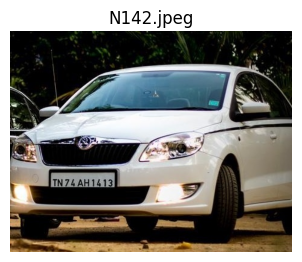

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Store images where OCR result was None
failed_images = []

for img_file in tqdm(image_files[:400]):
    img_path = os.path.join(data_path, img_file)
    result = ocr.ocr(img_path, cls=False)

    if not result or result[0] is None:
        failed_images.append(img_path)

# Display first 5 failed images
def show_images(image_paths, n=5):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:n]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(failed_images)


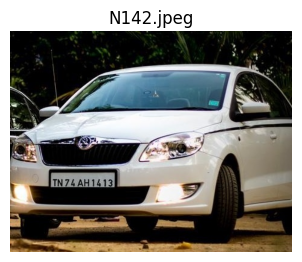

In [ ]:
def show_images(image_paths, start=0, count=5):
    end = min(start + count, len(image_paths))
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[start:end]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, count, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_images(failed_images, start=0, count=5)  # Shows images 6–10

In [ ]:
# Check how many total images you tried OCR on
print(f"Total images tried: {len(image_files)}")

# Check how many failed
print(f"Total failed OCR images: {len(failed_images)}")

# Check the main DataFrame shape
print(f"Main OCR DataFrame shape: {df_texts.shape}")


Total images tried: 228
Total failed OCR images: 1
Main OCR DataFrame shape: (100, 2)


So, there were not many images with non-english characters and we understand that our dataset has a huge bias toward english plates.
So, even suppose if we use PaddleOCR for other languages to be able to read the plates, our model will perform worse in detecting the plate itself.

Since plate detection model (YOLO, etc.) is trained only on English-styled rectangular plates, it may:

Miss plates in other formats (e.g., curved, handwritten, regional variants)

Misplace bounding boxes on unfamiliar plate styles